In [1]:
import sys 
sys.path.append('../')

import pandas as pd
import numpy as np

from scipy.special import softmax
from sklearn import preprocessing

from matplotlib import pyplot as plt
%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
test_probs_best, test_users_best, oldid2newid_best = np.load("../test_preds/antonlstm_anton_seqs_2048bs_30seqlen_rmsprop_byloss_fixedmetric_correctval.npy", allow_pickle=True)

In [3]:
test_probs_new, test_users_new, val_probs_new, val_pred_new, val_users_new, oldid2newid_new = np.load("../test_preds/timeval_3stage.npy", allow_pickle=True)

In [14]:
test_users_new == test_users_best

True

In [16]:
list(oldid2newid_best) == list(oldid2newid_new)

True

In [132]:
init_df = pd.read_csv("/ssd_data/cinema_hack/movies_dataset_10 months.csv")
init_df['ts'] = pd.to_datetime(init_df['ts'])
init_df = init_df.sort_values(by=["ts"])

movies_database = pd.read_csv("/ssd_data/cinema_hack/movies_database.csv")
movies_database["title_year"] = movies_database.title + "_" +  movies_database.year.astype(str) 

needed_columns = ["userID", "itemID", "title_year", "views"]
history = init_df.merge(movies_database[["id", "title_year"]], left_on="movie_id", right_on="id")
history = history.sort_values("ts").reset_index(drop=True)

In [141]:
init_df['ts'].iloc[0], init_df['ts'].iloc[1], (init_df['ts'].iloc[1] - init_df['ts'].iloc[0]).seconds / 60

(Timestamp('2019-10-01 00:01:31'),
 Timestamp('2019-10-01 00:01:38'),
 0.11666666666666667)

In [177]:
def filter_bad_watches(input, t_thresh=10.0):
    ts = input['ts'].tolist()
    if len(ts) > 1:
        shifted_ts = [(ts[i+1] - ts[i]).seconds / 60 for i in range(len(ts)-1)] + [1_000]
    else:
        shifted_ts = [1_000]
    movie_list = input['movie_id'].tolist()
    movie_list = [el for el, time in zip(movie_list,shifted_ts) if time > t_thresh]
    return movie_list

In [178]:
from itertools import chain

In [170]:
dur_in_mins = init_df.groupby('user_id').apply(try_func)

In [179]:
selected_movies = init_df.groupby('user_id').apply(try_func)

In [181]:
all_movies = init_df.groupby('user_id')['movie_id'].apply(list)

In [187]:
len(all_movies.iloc[0]), len(selected_movies.iloc[0])

(62, 49)

In [184]:
selected_movies.iloc[0]

[7436,
 4386,
 9017,
 16367,
 6121,
 17734,
 0,
 7347,
 17756,
 16499,
 10909,
 13124,
 4668,
 18696,
 18410,
 16544,
 9036,
 10318,
 8590,
 16506,
 10390,
 2357,
 10584,
 18964,
 2165,
 13378,
 18262,
 4624,
 9765,
 8290,
 10487,
 10630,
 15782,
 15541,
 17364,
 17999,
 17999,
 17999,
 17999,
 17999,
 17999,
 17999,
 1681,
 17195,
 10961,
 18524,
 7351,
 8893,
 16238]

In [176]:
(pd.Series(list(chain(*dur_in_mins))) > 15).value_counts(normalize=True)

True     0.761013
False    0.238987
dtype: float64

In [8]:
test_probs_best = np.stack(test_probs_best, axis=0).mean(0)

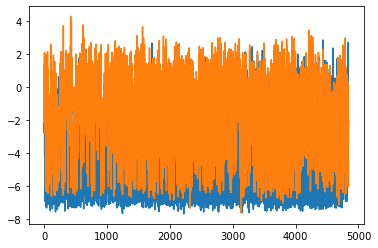

In [9]:
plt.plot(test_probs_best[0])
plt.plot(test_probs_new[0])

In [18]:
plt.plot(np.argsort(-test_probs_best)[0])
plt.plot(np.argsort(-test_probs_new)[0])

In [19]:
np.argsort(-test_probs_best)[0] == np.argsort(-test_probs_new)[0]

array([False, False, False, ..., False, False, False])

In [20]:
oldid2newid = oldid2newid_best

In [38]:
le = preprocessing.LabelEncoder()
le.classes_ = oldid2newid

In [54]:
def probs_to_movie_id(user_id, user_logits, history):

    
    sorted_indexes = np.argsort(user_logits)[::-1]
    recommended_movies_id = [oldid2newid[x] for x in sorted_indexes][:100]
    sorted_probs = softmax(np.sort(user_logits))[::-1][:100]

    result = []
    for recommended_movie, prob in zip(recommended_movies_id, sorted_probs):
        result.append({"user_id": user_id,
                       "movie_id":recommended_movie,
                       "prob": round(prob, 5)})

    result = pd.DataFrame(result)

    result = result.merge(movies_database[["id", "title_year", "available_now"]],
                      left_on="movie_id", right_on="id", how='left').drop("id", axis=1)

    
    result.available_now.fillna("yes", inplace=True)
    
    user_history = history[history.user_id == user_id].sort_values(by="ts").reset_index(drop=True)
    watched_films = user_history.iloc[-10:-5][user_history.episode_id == 0].movie_id.tolist()
    
    watched_films_in_predictions = list(set(result.movie_id.tolist()).intersection(watched_films))
    
    # filter out recently watched
    #result = result[~result.movie_id.isin(watched_films_in_predictions)]
    
    # filter out not available
    #result = result[(result.available_now == "yes")]   
    result.sort_values(by="prob", ascending=False, inplace=True)  
        
    
    return result

In [127]:
idx = 200
probs_to_movie_id(test_users_best[idx], test_probs_best[idx], history).head(10)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


user_id  movie_id     prob  \
0  2290687723052334082     15761  0.02283   
1  2290687723052334082     13654  0.01809   
2  2290687723052334082     11019  0.01760   
3  2290687723052334082     20249  0.01592   
4  2290687723052334082     18968  0.00997   
5  2290687723052334082     15541  0.00902   
6  2290687723052334082     18520  0.00897   
7  2290687723052334082     12243  0.00872   
8  2290687723052334082      5061  0.00820   
9  2290687723052334082     19335  0.00807   

                            title_year available_now  
0    Star Wars: The Force Awakens_2015            no  
1        Star Wars: The Last Jedi_2017            no  
2  Guardians of the Galaxy Vol. 2_2017            no  
3         Solo: A Star Wars Story_2018            no  
4                        Warcraft_2016           yes  
5                     Tomb Raider_2018            no  
6                   Captive State_2019           yes  
7               Blade Runner 2049_2017           yes  
8          Spider-Man: Homecoming_2017           yes  
9                    DeadTectives_2018            no

In [128]:
probs_to_movie_id(test_users_best[idx], test_probs_new[idx], history).head(10)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


user_id  movie_id     prob                         title_year  \
0  2290687723052334082     15387  0.01676                     Westworld_2016   
1  2290687723052334082     15541  0.01483                   Tomb Raider_2018   
2  2290687723052334082     10779  0.01067                       RoboCop_2014   
3  2290687723052334082      9292  0.00812                       Spectre_2015   
4  2290687723052334082      3588  0.00805                  Total Recall_2012   
5  2290687723052334082     15761  0.00728  Star Wars: The Force Awakens_2015   
6  2290687723052334082     18968  0.00710                      Warcraft_2016   
7  2290687723052334082      5061  0.00664        Spider-Man: Homecoming_2017   
8  2290687723052334082      3845  0.00663             Deepwater Horizon_2016   
9  2290687723052334082      1755  0.00623                        Looper_2012   

  available_now  
0           yes  
1            no  
2            no  
3            no  
4           yes  
5            no  
6           yes  
7           yes  
8           yes  
9           yes

In [129]:
history[history.user_id == test_users_best[idx]].tail(10)

ts              user_id  movie_id  episode_id     id  \
310795 2020-07-12 11:48:27  2290687723052334082     15295      115136  15295   
310816 2020-07-12 12:09:51  2290687723052334082     13098       53388  13098   
311215 2020-07-12 19:25:49  2290687723052334082     19851           0  19851   
315155 2020-07-17 13:42:12  2290687723052334082     17002           0  17002   
319990 2020-07-23 11:50:56  2290687723052334082     10826           0  10826   
321200 2020-07-24 19:17:05  2290687723052334082     15761           0  15761   
321203 2020-07-24 19:20:40  2290687723052334082      4637           0   4637   
321244 2020-07-24 19:58:28  2290687723052334082     13654           0  13654   
322158 2020-07-25 19:10:26  2290687723052334082     19287           0  19287   
322184 2020-07-25 19:50:27  2290687723052334082     20249           0  20249   

                                        title_year  
310795                            Killing Eve_2018  
310816                       Carter: Season 1_2018  
311215                            The Traitor_2019  
315155         Voyage of Time: Life's Journey_2016  
319990                              16 Blocks_2006  
321200           Star Wars: The Force Awakens_2015  
321203                           Seven Pounds_2008  
321244               Star Wars: The Last Jedi_2017  
322158  Fast & Furious Presents: Hobbs & Shaw_2019  
322184                Solo: A Star Wars Story_2018

In [92]:
history['ts'] = pd.to_datetime(history['ts'])

In [97]:
(history['ts'].iloc[0] - history['ts'].iloc[1]).se

Timedelta('-106752 days +00:12:43.145224193')

In [109]:
movies_database[movies_database.title == 'Inseparable']

id  year        title  \
14629  17694  2013  Inseparable   

                                             description genres  \
14629  It's April of 1986. Pripyat, Ukraine. A core m...  Drama   

               director                                             actors  \
14629  Vitaliy Vorobyov  Julia Rutberg,Evgenia Loza,Andrey Kazakov,Mari...   

      writers music  art producer    imdb_id  tmdb_id  imdb_rating  \
14629     NaN   NaN  NaN      NaN  tt2934916  55886.0          7.6   

       tmdb_rating available_now        title_year  
14629          6.8           yes  Inseparable_2013

In [114]:
init_df.loc[init_df.movie_id == 17694]

ts               user_id  movie_id  episode_id
106     2019-10-01 08:34:46  11725055962489554328     17694      105933
132     2019-10-01 09:23:14  11725055962489554328     17694      105934
167     2019-10-01 10:13:01  11725055962489554328     17694      105935
201     2019-10-01 11:02:22  11725055962489554328     17694      105936
5887    2019-10-05 17:14:55   9796311143660199232     17694      105933
...                     ...                   ...       ...         ...
322947  2020-07-05 12:01:45   1179974583240091468     17694      105934
322951  2020-07-05 12:04:19   1179974583240091468     17694      105935
322953  2020-07-05 12:05:25   1179974583240091468     17694      105936
325922  2020-07-08 19:07:51   8160415407453552014     17694      105933
328171  2020-07-11 16:26:05  11060998217522666704     17694      105933

[121 rows x 4 columns]

In [2]:
new_history = pd.read_csv('../add_data/movies_dataset_10_months_extend.csv')

In [4]:
new_history['ts'] = pd.to_datetime(new_history['ts'])

In [10]:
new_history['ts'].iloc[0], new_history['ts'].iloc[0].dayofweek, new_history['ts'].iloc[0].month, new_history['ts'].iloc[0].hour, new_history['ts'].iloc[0].year 

(Timestamp('2019-10-01 00:01:31'), 1, 10, 0, 2019)